In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_530910/1483615387.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


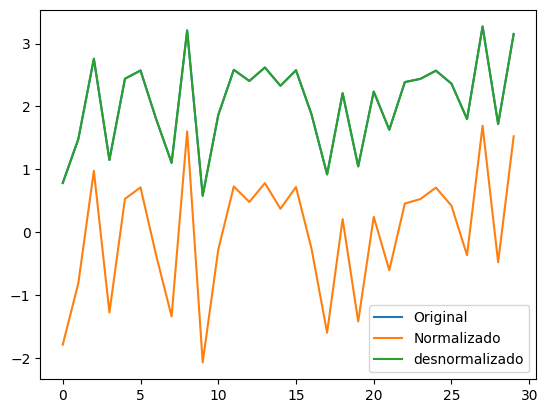

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-07-31 02:27:01.526370: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 02:27:01.556441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 02:27:01.556472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 02:27:01.557474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 02:27:01.562724: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 02:27:01.563514: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-07-31 02:27:02.575611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product

class Tester:
  def __init__(self, _df, _df_1000,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(_df=df_virtual_norm,
                _df_1000=df_1000_norm,
                run_times=50, dataset_run_times=10)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 11 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 12 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 13 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 14 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 15 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 16 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 17 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 19 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 172ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 21 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 22 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 23 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 24 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 25 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 26 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 27 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 28 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 29 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 30 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 31 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 32 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 33 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 35 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 37 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 38 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 39 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 40 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 41 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 42 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 43 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 44 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 45 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 46 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 47 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 48 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 49 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 50 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_49,0.962718,0.685176,0.935167,0.947040,0.944555,0.015665,0.186893,0.020902,0.028493,0.024698,0.067506,0.125160,0.922329,0.126165,138.312656,322.670980
model_1_0_48,0.961780,0.684385,0.933995,0.945460,0.943177,0.016059,0.187363,0.021280,0.029343,0.025311,0.068173,0.126724,0.920375,0.127742,138.262971,322.621295
model_1_0_47,0.956461,0.679595,0.926490,0.937736,0.935796,0.018294,0.190206,0.023699,0.033499,0.028599,0.072651,0.135255,0.909293,0.136342,138.002364,322.360688
model_1_0_46,0.954939,0.677291,0.923861,0.935547,0.933523,0.018933,0.191574,0.024547,0.034676,0.029611,0.073979,0.137598,0.906124,0.138703,137.933671,322.291995
model_1_0_45,0.952238,0.674956,0.919777,0.931721,0.929734,0.020068,0.192960,0.025864,0.036735,0.031299,0.076107,0.141662,0.900496,0.142800,137.817240,322.175564
model_1_0_44,0.951363,0.674355,0.918406,0.930586,0.928553,0.020436,0.193317,0.026305,0.037345,0.031825,0.076802,0.142954,0.898674,0.144102,137.780939,322.139263
model_1_0_43,0.950497,0.673674,0.917023,0.929490,0.927390,0.020800,0.193721,0.026752,0.037935,0.032343,0.077462,0.144222,0.896868,0.145380,137.745613,322.103937
model_1_0_42,0.949528,0.672969,0.915537,0.928038,0.925976,0.021207,0.194140,0.027231,0.038716,0.032973,0.078207,0.145626,0.894850,0.146796,137.706846,322.065170
model_1_0_40,0.944121,0.669562,0.909657,0.921469,0.919880,0.023479,0.196162,0.029126,0.042251,0.035688,0.082394,0.153228,0.883585,0.154459,137.503308,321.861632
model_1_0_41,0.945342,0.669378,0.910804,0.922609,0.920984,0.022966,0.196271,0.028756,0.041637,0.035197,0.081544,0.151545,0.886129,0.152762,137.547500,321.905824


DataFrame salvo em ../results/metrics_1_0


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 11 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 12 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 13 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 14 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 15 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 16 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 17 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 19 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 21 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 22 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 23 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 24 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 25 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 26 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 27 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 28 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 29 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 30 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 31 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 32 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 33 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 34 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 35 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 37 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 38 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 39 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 40 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 41 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 42 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 43 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 44 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 45 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 46 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 47 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 48 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 49 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_39,0.997388,0.715076,0.997565,0.996480,0.997151,0.001098,0.169143,0.001322,0.001352,0.001337,0.017213,0.033131,0.994557,0.033397,143.629142,327.987466
model_1_1_37,0.997246,0.714870,0.997538,0.996343,0.997079,0.001157,0.169265,0.001337,0.001405,0.001371,0.017774,0.034017,0.994263,0.034290,143.523632,327.881956
model_1_1_38,0.997287,0.714817,0.997560,0.996378,0.997105,0.001140,0.169297,0.001325,0.001391,0.001358,0.017627,0.033764,0.994347,0.034035,143.553407,327.911731
model_1_1_40,0.997675,0.714549,0.998047,0.996943,0.997619,0.000977,0.169456,0.001061,0.001174,0.001117,0.016024,0.031256,0.995156,0.031507,143.862125,328.220449
model_1_1_41,0.997846,0.713758,0.998308,0.997084,0.997828,0.000905,0.169926,0.000919,0.001120,0.001019,0.015315,0.030087,0.995512,0.030329,144.014641,328.372965
model_1_1_43,0.998119,0.713740,0.998299,0.997366,0.997938,0.000790,0.169936,0.000924,0.001012,0.000968,0.014234,0.028112,0.996081,0.028338,144.286195,328.644519
model_1_1_42,0.997875,0.713724,0.998308,0.997111,0.997839,0.000893,0.169946,0.000919,0.001110,0.001014,0.015196,0.029882,0.995572,0.030122,144.041941,328.400264
model_1_1_44,0.998158,0.713463,0.998330,0.997402,0.997970,0.000774,0.170101,0.000907,0.000998,0.000953,0.014028,0.027817,0.996163,0.028041,144.328406,328.686730
model_1_1_45,0.998186,0.713437,0.998357,0.997427,0.997996,0.000762,0.170116,0.000893,0.000988,0.000940,0.013913,0.027606,0.996221,0.027828,144.358851,328.717175
model_1_1_48,0.998440,0.713019,0.998309,0.997984,0.998196,0.000656,0.170364,0.000918,0.000774,0.000846,0.012736,0.025604,0.996749,0.025810,144.659970,329.018294


DataFrame salvo em ../results/metrics_1_1


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 11 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 12 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 13 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 14 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 15 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 16 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 17 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 19 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 21 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 22 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 23 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 24 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 25 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 26 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 27 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 28 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 29 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 30 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 31 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 32 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 33 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 35 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 37 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 38 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 39 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 40 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 41 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 42 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 43 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 44 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 45 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 46 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 47 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 49 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 50 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_0,0.998692,0.712653,0.997897,0.998255,0.998070,0.000549,0.170582,0.000797,0.000570,0.000683,0.011748,0.023439,0.997276,0.023628,145.013334,329.371658
model_1_2_1,0.998809,0.712494,0.998006,0.998318,0.998158,0.000500,0.170676,0.000755,0.000549,0.000652,0.011088,0.022366,0.997520,0.022545,145.200891,329.559215
model_1_2_2,0.998866,0.712169,0.998047,0.998375,0.998206,0.000477,0.170869,0.000740,0.000530,0.000635,0.010835,0.021830,0.997637,0.022005,145.297967,329.656291
model_1_2_3,0.998893,0.712108,0.998042,0.998409,0.998219,0.000465,0.170905,0.000742,0.000519,0.000631,0.010666,0.021571,0.997693,0.021744,145.345637,329.703961
model_1_2_4,0.998898,0.711891,0.998031,0.998402,0.998210,0.000463,0.171034,0.000746,0.000522,0.000634,0.010610,0.021517,0.997704,0.021690,145.355580,329.713904
model_1_2_5,0.998926,0.711796,0.998046,0.998427,0.998230,0.000451,0.171090,0.000740,0.000513,0.000627,0.010438,0.021243,0.997763,0.021413,145.406974,329.765298
model_1_2_7,0.998983,0.711699,0.998039,0.998466,0.998244,0.000427,0.171148,0.000743,0.000501,0.000622,0.010131,0.020676,0.997880,0.020842,145.515221,329.873545
model_1_2_6,0.998970,0.711617,0.998062,0.998429,0.998239,0.000433,0.171197,0.000734,0.000513,0.000623,0.010150,0.020808,0.997853,0.020975,145.489751,329.848075
model_1_2_8,0.999050,0.711537,0.998027,0.998514,0.998260,0.000399,0.171244,0.000747,0.000485,0.000616,0.009682,0.019980,0.998021,0.020141,145.652002,330.010326
model_1_2_10,0.999081,0.711257,0.997903,0.998370,0.998127,0.000386,0.171410,0.000794,0.000532,0.000663,0.009170,0.019649,0.998086,0.019807,145.718941,330.077265


DataFrame salvo em ../results/metrics_1_2


+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 11 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 12 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 13 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 14 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 15 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 16 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 17 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 19 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 21 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 22 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 23 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 24 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 25 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 26 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 27 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 28 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 30 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 31 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 32 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 33 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 34 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 35 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 36 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 37 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 38 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 39 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 40 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 41 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 42 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 43 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 44 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 45 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 46 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 47 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 49 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 50 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_48,0.998488,0.714961,0.991109,0.998573,0.995482,0.000635,0.169211,0.003161,0.000717,0.001939,0.007359,0.025206,0.996850,0.025409,144.722672,329.080996
model_1_3_49,0.998452,0.714944,0.990887,0.998526,0.995362,0.000650,0.169221,0.003240,0.000741,0.001991,0.007377,0.025502,0.996775,0.025707,144.675978,329.034302
model_1_3_47,0.998517,0.714894,0.991286,0.998616,0.995580,0.000623,0.169251,0.003099,0.000696,0.001897,0.007339,0.024960,0.996911,0.025161,144.761905,329.120229
model_1_3_46,0.998524,0.714857,0.991327,0.998629,0.995605,0.000620,0.169273,0.003084,0.000689,0.001887,0.007333,0.024901,0.996925,0.025101,144.771324,329.129648
model_1_3_45,0.998536,0.714632,0.991415,0.998657,0.995657,0.000615,0.169407,0.003053,0.000675,0.001864,0.007359,0.024799,0.996951,0.024998,144.787824,329.146148
model_1_3_44,0.998530,0.714596,0.991403,0.998642,0.995644,0.000618,0.169428,0.003057,0.000683,0.001870,0.007372,0.024850,0.996938,0.025050,144.779569,329.137893
model_1_3_43,0.998531,0.714558,0.991423,0.998636,0.995648,0.000617,0.169451,0.003050,0.000686,0.001868,0.007376,0.024842,0.996940,0.025041,144.780954,329.139278
model_1_3_42,0.998541,0.714503,0.991484,0.998650,0.995682,0.000613,0.169483,0.003028,0.000679,0.001853,0.007373,0.024758,0.996961,0.024957,144.794461,329.152785
model_1_3_41,0.998527,0.714451,0.991429,0.998624,0.995644,0.000619,0.169514,0.003048,0.000692,0.001870,0.007393,0.024878,0.996931,0.025078,144.775018,329.133342
model_1_3_39,0.998530,0.714197,0.991582,0.998581,0.995682,0.000618,0.169665,0.002993,0.000714,0.001854,0.007508,0.024852,0.996938,0.025051,144.779347,329.137671


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  22
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  62
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 11 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 12 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 13 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 14 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 15 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 16 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 17 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 19 ++++++++++++++++++


Stopped at epoch:  33
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 21 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 22 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 23 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 24 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 25 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 26 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 27 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 28 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 29 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 30 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 31 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 32 ++++++++++++++++++


Stopped at epoch:  37
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 33 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 35 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 36 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 37 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 38 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 39 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 40 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 41 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 42 ++++++++++++++++++


Stopped at epoch:  28
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 43 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 44 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 45 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 46 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 49 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,0.998802,0.712854,0.998931,0.999840,0.999465,0.000503,0.170463,0.000329,0.000069,0.000199,0.007447,0.022434,0.997505,0.022615,145.188651,329.546975
model_1_4_2,0.999262,0.709589,0.997949,0.999480,0.998849,0.000310,0.172401,0.000632,0.000225,0.000428,0.007061,0.017611,0.998462,0.017753,146.156914,330.515238
model_1_4_4,0.999268,0.709446,0.997892,0.999455,0.998811,0.000307,0.172485,0.000649,0.000236,0.000443,0.007072,0.017535,0.998475,0.017676,146.174287,330.532611
model_1_4_5,0.999274,0.709415,0.997881,0.999453,0.998806,0.000305,0.172504,0.000653,0.000237,0.000445,0.007035,0.017465,0.998488,0.017605,146.190176,330.548500
model_1_4_1,0.999260,0.709397,0.997928,0.999486,0.998844,0.000311,0.172515,0.000638,0.000222,0.000430,0.007185,0.017630,0.998459,0.017771,146.152691,330.511015
model_1_4_3,0.999271,0.709387,0.997921,0.999467,0.998830,0.000306,0.172520,0.000641,0.000231,0.000436,0.007019,0.017497,0.998482,0.017638,146.182874,330.541198
model_1_4_6,0.999315,0.708589,0.997644,0.999382,0.998666,0.000288,0.172994,0.000726,0.000268,0.000497,0.006893,0.016961,0.998574,0.017097,146.307432,330.665756
model_1_4_7,0.999314,0.708122,0.997565,0.999344,0.998612,0.000288,0.173271,0.000750,0.000284,0.000517,0.006882,0.016983,0.998570,0.017119,146.302233,330.660557
model_1_4_8,0.999317,0.708076,0.997556,0.999341,0.998606,0.000287,0.173298,0.000753,0.000285,0.000519,0.006859,0.016940,0.998577,0.017076,146.312378,330.670702
model_1_4_17,0.999326,0.708019,0.997172,0.999154,0.998339,0.000283,0.173333,0.000871,0.000366,0.000619,0.006622,0.016834,0.998595,0.016969,146.337435,330.695759


DataFrame salvo em ../results/metrics_1_4


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  34
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 11 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 12 ++++++++++++++++++


Stopped at epoch:  42
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 13 ++++++++++++++++++


Stopped at epoch:  28
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 14 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 15 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 16 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 17 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 19 ++++++++++++++++++


Stopped at epoch:  33
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 21 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 22 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 23 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 24 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 25 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 26 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 27 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 28 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 30 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 31 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 32 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 33 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 35 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 37 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 38 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 39 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 40 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 41 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 42 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 43 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 44 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 45 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 46 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 47 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 49 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_1,0.999589,0.705941,0.999540,0.999345,0.999472,0.000173,0.174566,0.000222,0.000308,0.000265,0.004922,0.013147,0.999143,0.013252,147.326370,331.684694
model_1_5_0,0.999577,0.705938,0.999539,0.999345,0.999472,0.000178,0.174568,0.000222,0.000308,0.000265,0.004864,0.013337,0.999118,0.013444,147.268958,331.627282
model_1_5_2,0.999590,0.705800,0.999541,0.999348,0.999474,0.000172,0.174650,0.000221,0.000306,0.000264,0.004956,0.013126,0.999146,0.013232,147.332512,331.690836
model_1_5_3,0.999591,0.705794,0.999537,0.999343,0.999470,0.000172,0.174653,0.000223,0.000309,0.000266,0.004954,0.013102,0.999149,0.013207,147.340101,331.698425
model_1_5_4,0.999618,0.705140,0.999531,0.999286,0.999440,0.000161,0.175042,0.000226,0.000336,0.000281,0.004853,0.012673,0.999204,0.012775,147.473156,331.831479
model_1_5_6,0.999621,0.705079,0.999473,0.999185,0.999365,0.000159,0.175078,0.000254,0.000383,0.000318,0.004846,0.012619,0.999210,0.012720,147.490178,331.848502
model_1_5_5,0.999629,0.705050,0.999495,0.999230,0.999396,0.000156,0.175095,0.000243,0.000362,0.000303,0.004730,0.012485,0.999227,0.012585,147.533018,331.891342
model_1_5_7,0.999627,0.704649,0.999465,0.999121,0.999331,0.000157,0.175333,0.000258,0.000413,0.000336,0.004841,0.012522,0.999223,0.012623,147.521043,331.879367
model_1_5_8,0.999628,0.704391,0.999454,0.999080,0.999307,0.000156,0.175487,0.000263,0.000432,0.000348,0.004835,0.012501,0.999225,0.012601,147.527837,331.886161
model_1_5_9,0.999629,0.704327,0.999446,0.999029,0.999279,0.000156,0.175525,0.000267,0.000457,0.000362,0.004853,0.012488,0.999227,0.012588,147.531964,331.890288


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 11 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 12 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 13 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 14 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 15 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 16 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 17 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 18 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 19 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 21 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 22 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 23 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 24 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 25 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 26 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 27 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 28 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 29 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 30 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 31 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 32 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 33 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 35 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 37 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 38 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 39 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 40 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 41 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 42 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 43 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 44 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 45 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 46 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 49 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_32,0.999138,0.703876,0.997895,0.997315,0.997652,0.000362,0.175792,0.001024,0.000986,0.001005,0.006416,0.019027,0.998205,0.019180,145.847574,330.205898
model_1_6_31,0.999164,0.703814,0.997980,0.997473,0.997768,0.000351,0.175829,0.000983,0.000929,0.000956,0.006440,0.018745,0.998258,0.018896,145.907322,330.265646
model_1_6_29,0.999223,0.703576,0.998200,0.997670,0.997978,0.000326,0.175970,0.000876,0.000856,0.000866,0.006361,0.018068,0.998381,0.018213,146.054529,330.412853
model_1_6_30,0.999219,0.703531,0.998183,0.997649,0.997959,0.000328,0.175997,0.000884,0.000864,0.000874,0.006364,0.018119,0.998372,0.018265,146.043098,330.401422
model_1_6_36,0.999047,0.703448,0.997421,0.997163,0.997318,0.000401,0.176046,0.001255,0.001042,0.001148,0.006444,0.020015,0.998014,0.020175,145.645159,330.003483
model_1_6_28,0.999213,0.703447,0.998123,0.997739,0.997964,0.000331,0.176047,0.000913,0.000831,0.000872,0.006386,0.018185,0.998360,0.018331,146.028547,330.386871
model_1_6_24,0.999267,0.703404,0.998372,0.997951,0.998196,0.000308,0.176072,0.000792,0.000753,0.000773,0.006310,0.017546,0.998474,0.017687,146.171719,330.530043
model_1_6_25,0.999268,0.703362,0.998372,0.997931,0.998188,0.000308,0.176097,0.000792,0.000760,0.000776,0.006313,0.017541,0.998474,0.017682,146.172835,330.531159
model_1_6_26,0.999233,0.703298,0.998248,0.997780,0.998052,0.000322,0.176135,0.000853,0.000815,0.000834,0.006397,0.017953,0.998402,0.018098,146.079896,330.438220
model_1_6_23,0.999294,0.703287,0.998528,0.997989,0.998301,0.000297,0.176142,0.000716,0.000739,0.000728,0.006312,0.017221,0.998529,0.017360,146.246396,330.604720


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  30
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 11 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 12 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 13 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 14 ++++++++++++++++++


Stopped at epoch:  25
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 15 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 16 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 17 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 19 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 21 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 22 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 23 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 24 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 25 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 26 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 27 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 28 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 1s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 30 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 31 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 32 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 33 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 34 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 35 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 37 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 38 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 39 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 40 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 41 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 42 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 43 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 44 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 45 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 46 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 47 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 48 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 49 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_29,0.999180,0.702039,0.998828,0.994309,0.997281,0.000344,0.176883,0.000551,0.001406,0.000978,0.006201,0.018559,0.998292,0.018708,145.947281,330.305605
model_1_7_30,0.999175,0.702026,0.998808,0.994281,0.997258,0.000347,0.176890,0.000560,0.001413,0.000987,0.006218,0.018623,0.998280,0.018773,145.933418,330.291742
model_1_7_41,0.998798,0.701934,0.997737,0.991780,0.995699,0.000505,0.176945,0.001064,0.002031,0.001547,0.006509,0.022477,0.997495,0.022658,145.181054,329.539378
model_1_7_33,0.998996,0.701906,0.998319,0.993046,0.996514,0.000422,0.176961,0.000790,0.001718,0.001254,0.006373,0.020539,0.997908,0.020704,145.541711,329.900035
model_1_7_32,0.999043,0.701895,0.998470,0.993344,0.996715,0.000402,0.176968,0.000719,0.001645,0.001182,0.006355,0.020052,0.998006,0.020213,145.637680,329.996004
model_1_7_40,0.998814,0.701887,0.997780,0.991889,0.995765,0.000499,0.176973,0.001043,0.002004,0.001524,0.006506,0.022327,0.997528,0.022507,145.207773,329.566097
model_1_7_31,0.999092,0.701858,0.998601,0.993688,0.996919,0.000381,0.176990,0.000657,0.001560,0.001108,0.006315,0.019529,0.998109,0.019686,145.743327,330.101651
model_1_7_37,0.998935,0.701776,0.998141,0.992669,0.996269,0.000447,0.177039,0.000874,0.001811,0.001342,0.006450,0.021150,0.997782,0.021320,145.424468,329.782792
model_1_7_35,0.998954,0.701773,0.998194,0.992796,0.996347,0.000439,0.177040,0.000849,0.001780,0.001314,0.006439,0.020962,0.997821,0.021131,145.460101,329.818425
model_1_7_36,0.998946,0.701765,0.998171,0.992737,0.996312,0.000443,0.177045,0.000859,0.001794,0.001327,0.006443,0.021046,0.997804,0.021215,145.444146,329.802470


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  30
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 11 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 12 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 13 ++++++++++++++++++


Stopped at epoch:  77
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 14 ++++++++++++++++++


Stopped at epoch:  46
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 15 ++++++++++++++++++


Stopped at epoch:  46
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 16 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 17 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 18 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 19 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 21 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 22 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 23 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 24 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 25 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 26 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 27 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 28 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 30 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 31 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 32 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 33 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 34 ++++++++++++++++++


Stopped at epoch:  36
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 35 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 36 ++++++++++++++++++


Stopped at epoch:  41
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 37 ++++++++++++++++++


Stopped at epoch:  22
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 38 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 39 ++++++++++++++++++


Stopped at epoch:  66
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 40 ++++++++++++++++++


Stopped at epoch:  43
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 41 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 42 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 43 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 44 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 45 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 46 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 47 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 48 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 49 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 50 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_11,0.999309,0.708337,0.999320,0.999708,0.999537,0.000290,0.173144,0.000300,0.000164,0.000232,0.007043,0.017040,0.998560,0.017177,146.288703,330.647027
model_1_8_10,0.999300,0.708327,0.999320,0.999707,0.999537,0.000294,0.173150,0.000300,0.000164,0.000232,0.007071,0.017155,0.998541,0.017293,146.261782,330.620106
model_1_8_12,0.999575,0.706080,0.999163,0.999502,0.999353,0.000178,0.174483,0.000369,0.000279,0.000324,0.006180,0.013359,0.999115,0.013467,147.262111,331.620435
model_1_8_8,0.999157,0.705991,0.998960,0.999717,0.999384,0.000354,0.174536,0.000458,0.000158,0.000308,0.007880,0.018826,0.998243,0.018977,145.890161,330.248485
model_1_8_9,0.999169,0.705961,0.998969,0.999716,0.999388,0.000349,0.174554,0.000454,0.000159,0.000307,0.007828,0.018681,0.998270,0.018831,145.921092,330.279416
model_1_8_13,0.999571,0.705863,0.998919,0.999320,0.999144,0.000180,0.174612,0.000476,0.000381,0.000429,0.006053,0.013425,0.999106,0.013532,147.242666,331.600990
model_1_8_16,0.999509,0.705675,0.998533,0.999031,0.998813,0.000206,0.174724,0.000646,0.000542,0.000594,0.005754,0.014367,0.998977,0.014482,146.971330,331.329654
model_1_8_14,0.999534,0.705656,0.998656,0.999149,0.998933,0.000196,0.174736,0.000592,0.000476,0.000534,0.005946,0.013991,0.999029,0.014103,147.077380,331.435704
model_1_8_15,0.999516,0.705503,0.998563,0.999070,0.998847,0.000203,0.174826,0.000633,0.000521,0.000577,0.005824,0.014258,0.998992,0.014372,147.001866,331.360190
model_1_8_17,0.999505,0.705309,0.998473,0.999014,0.998776,0.000208,0.174941,0.000673,0.000552,0.000613,0.005630,0.014428,0.998968,0.014544,146.954335,331.312659


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 11 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 12 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 13 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 14 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 15 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 16 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 17 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 18 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 19 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 21 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 22 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 23 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 24 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 25 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 26 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 27 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 28 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 29 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 30 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 31 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 32 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 33 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 35 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 36 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 37 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 38 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 39 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 40 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 41 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 42 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 43 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 44 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 45 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 46 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 48 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 49 ++++++++++++++++++


Stopped at epoch:  43
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 50 ++++++++++++++++++


Stopped at epoch:  44
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_1,0.999535,0.701641,0.999229,0.999874,0.999607,0.000195,0.177119,0.000278,0.000062,0.000170,0.005001,0.013979,0.999031,0.014092,147.080725,331.439049
model_1_9_2,0.999544,0.701578,0.999225,0.999878,0.999607,0.000192,0.177156,0.000280,0.000060,0.000170,0.004941,0.013844,0.999050,0.013956,147.119474,331.477798
model_1_9_3,0.999561,0.701407,0.999266,0.999872,0.999621,0.000184,0.177258,0.000265,0.000063,0.000164,0.004897,0.013576,0.999086,0.013685,147.197817,331.556141
model_1_9_0,0.999513,0.701171,0.999398,0.999928,0.999708,0.000204,0.177398,0.000217,0.000035,0.000126,0.004755,0.014300,0.998986,0.014414,146.990102,331.348426
model_1_9_8,0.999504,0.701101,0.998774,0.999383,0.999138,0.000208,0.177440,0.000442,0.000303,0.000373,0.005401,0.014432,0.998967,0.014548,146.953302,331.311626
model_1_9_6,0.999509,0.701099,0.998794,0.999422,0.999168,0.000207,0.177441,0.000435,0.000284,0.000360,0.005413,0.014370,0.998976,0.014486,146.970349,331.328673
model_1_9_7,0.999509,0.701045,0.998790,0.999403,0.999156,0.000206,0.177473,0.000437,0.000293,0.000365,0.005395,0.014369,0.998976,0.014484,146.970779,331.329103
model_1_9_12,0.999454,0.700677,0.998478,0.998930,0.998757,0.000229,0.177691,0.000549,0.000526,0.000538,0.005282,0.015145,0.998863,0.015267,146.760312,331.118636
model_1_9_11,0.999458,0.700665,0.998483,0.998962,0.998777,0.000228,0.177698,0.000547,0.000511,0.000529,0.005289,0.015085,0.998872,0.015207,146.776120,331.134444
model_1_9_13,0.999449,0.700645,0.998451,0.998908,0.998733,0.000231,0.177710,0.000559,0.000537,0.000548,0.005280,0.015214,0.998852,0.015336,146.742110,331.100434


DataFrame salvo em ../results/metrics_1_9
